*Verified by Leila Belabbassi (to work with Pangeo), July 9, 2018*


# Pioneer Upstream Offshore Profiler (CP02PMUO) Example Data Quality Report

**Evaluation Date**: 4/20/2018

**Evaluator**: Sage Lichtenwalner

## Review Summary
This report summarizes an example data quality review of the Pioneer Upstream Offshore Profiler Mooring (CP02PMUO).  We focus on data from the summer of 2017 (Deployment 9), and compare the profiler's CTD with a cruise CTD collected on October 24, 2017.  This report is not necessarily a comprehensive review of the instruments and quality of the data available.  Rather, it demonstrates the key steps that we recommend including when reviewing any given dataset you wish to verify.  

In general, a review might focus on some or all of the following steps, some of which may be repeated for different instrument or time periods of interest:
* Data Availability
  * What data are available? Are they relevant to the study you wish to pursue?
* Metadata
  * What metadata are available? Are they complete? Is anything missing? What does it tell you about the dataset (for good or bad)?
* Understand the context
  * Plot a large range of data. Does it look right based on what you would expect? What are the ranges, and do they make sense?
* Focus on one or more smaller ranges
  * Plot some smaller periods (in space or time) to see if they look correct or have issues.
* Environmental Comparisons
  * Compare the dataset with other datasets, like cruise/shipboard data, satellites, gliders, and neighboring instruments (which could be of the same type or different).

This review attempts to demonstrate each of the above steps, while not diving too deeply into specific data issues. Keep in mind that reviewing data quality can be a very large rabbit hole. The trick is to figure out how far down you really need to go to make sure the data are correct and appropriate for the science you wish to do, and don't go any further. We summarize a few notes and recommendations at the end.

## 1. Selected instruments included in this report
In this report, we will evaluate the CTD (specifically temperature and salinity) from the Pioneer Upstream Offshore Profiler (CP02PMUO), focusing on the summer of 2017 (Deployment 9). Additional instruments on the profiler are listed for reference and could be used for further evaluation.

Instrument | Reference Designator | Method | Stream 
 -- | -- | -- | --
CTD | [CP02PMUO-WFP01-03-CTDPFK000](http://ooi.visualocean.net/instruments/view/CP02PMUO-WFP01-03-CTDPFK000) | telemetered | ctdpf_ckl_wfp_instrument
Dissolved Oxygen | CP02PMUO-WFP01-02-DOFSTK000 | telemetered | dofst_k_wfp_instrument
Fluorometer | CP02PMUO-WFP01-04-FLORTK000 | telemetered | flort_sample
PAR | CP02PMUO-WFP01-05-PARADK000 | telemetered | parad_k__stc_imodem_instrument

We focus on the telmetered data stream in this review because the recovered data are not yet available in the system for Deployment 9 (June 2017 and beyond). A graph of data availability is available at http://ooi.visualocean.net/instruments/stats-monthly/CP02PMUO-WFP01-03-CTDPFK000.

In [1]:
# Setup Instrument Variables
site = 'CP02PMUO'
node = 'WFP01'
instrument = '03-CTDPFK000'
method = 'telemetered'
stream = 'ctdpf_ckl_wfp_instrument'

## 2. Time periods of interest
We will focus on the following time periods for evaluation:
* June 7, 2017 to November 11, 2017 - All of Deployment 9 (see step 4)
* One week around June 7, 2017 - The changeover from Deployment 8 to 9 (see step 5)
* October 24, 2017 - The day of the cruise CTD cast (see step 6)


## 3. Related Metadata
In this section, we will review some of metadata available in the system to make sure it is present and correct.

Before we get started, we need to set up our Python environment with some libraries, variables and functions we will need later in this report.

In [2]:
# Setup the Python processing environment 
import requests
import datetime
import pandas as pd


In [3]:
# API Information
USERNAME ='OOIAPI-D8S960UXPK4K03'
TOKEN= 'IXL48EQ2XY'

DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'


In [4]:
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None


### 3a. Vocabulary Metadata
First, let's grab the basic vocabulary information (metadata) from the system to make sure we have the right instrument.

In [5]:
# Setup the API request url
data_request_url ='/'.join((VOCAB_API,site,node,instrument))
print(data_request_url)

# Grab the information from the server
r = requests.get(data_request_url, auth=(USERNAME, TOKEN))
data = r.json()
data

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/CP02PMUO/WFP01/03-CTDPFK000


[{'@class': '.VocabRecord',
  'model': 'SBE 52MP',
  'manufacturer': 'Sea-Bird',
  'vocabId': 534,
  'refdes': 'CP02PMUO-WFP01-03-CTDPFK000',
  'instrument': 'CTD',
  'tocL1': 'Coastal Pioneer',
  'tocL2': 'Upstream Offshore Profiler Mooring',
  'tocL3': 'Wire-Following Profiler',
  'mindepth': 20.0,
  'maxdepth': 425.0}]

All this looks good!

### 3b. Deployment Information
Next, let's grab some information about the deployments for this instrument.  We will grab all of the deployments available in the system for 2017 and then output the date ranges, latitude/longitude, asset ID, and sensor ID for each.  Note that the **reference designator** specified above represents the geographical location of an instrument across all deployments (e.g. the CTD on the Pioneer Upstream Offshore Profiler), the **Sensor ID** (and its Asset ID equivalent) represent the specific instrument used for a given deployment (i.e. a unique make, model, and serial numbered instrument).

In [6]:
# Setup the API request url
data_request_url = ASSET_API + '/events/deployment/query'
params = {
  'beginDT':'2017-01-01T00:00:00.000Z',
  'endDT':'2018-01-01T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+instrument,   
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,1716.0,8.0,39.939350,-70.770800,CGINS-CTDPFK-00169,2016-10-02 00:26:00,2017-06-07 12:08:00
1,1644.0,9.0,39.941200,-70.780367,CGINS-CTDPFK-00127,2017-06-07 18:53:00,2017-11-11 12:45:00
2,1649.0,10.0,39.938667,-70.770050,CGINS-CTDPFK-00124,2017-11-11 20:42:00,2018-04-10 10:15:00


### 3c. Calibration Information
When the system delivers data, it often uses a number of calibration coefficients to generated derived data products.

It turns out that this CTD instrument doesn't have any calibration information, because none is required by the system.

Instead, as an example of what the calibration information might look like (and to make sure something has been added to the system for this deployment), let's pull the calibration information for the neighboring FLORT for Deployment 9.  

Because the asset API can return confusing results, we will limit the search to just one day within the deployment time range.

In [7]:
# Setup the API request url
data_request_url = ASSET_API + '/asset/cal'
params = {
  'beginDT':'2017-07-01T00:00:00.000Z',
  'endDT':'2017-07-02T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+'04-FLORTK000',
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# Reformat the data into a pretty table
df = pd.DataFrame() # Setup empty array
for d in data:
  for dd in d['sensor']['calibration']:
    for ddd in dd['calData']:
      df = df.append({
        'value': ddd['value'],
        'start': convert_time(ddd['eventStartTime']),
        'stop': convert_time(ddd['eventStopTime']),
        'name': ddd['eventName'],
        'assetUid': ddd['assetUid'],
        }, ignore_index=True)
    
df = df.sort_values(by=['start','name'])
df


,assetUid,name,start,stop,value
1,CGINS-FLORTK-01100,CC_angular_resolution,2016-12-12,None,1.076000
3,CGINS-FLORTK-01100,CC_dark_counts_cdom,2016-12-12,None,47.000000
4,CGINS-FLORTK-01100,CC_dark_counts_chlorophyll_a,2016-12-12,None,48.000000
8,CGINS-FLORTK-01100,CC_dark_counts_volume_scatter,2016-12-12,None,49.000000
7,CGINS-FLORTK-01100,CC_depolarization_ratio,2016-12-12,None,0.039000
2,CGINS-FLORTK-01100,CC_measurement_wavelength,2016-12-12,None,700.000000
9,CGINS-FLORTK-01100,CC_scale_factor_cdom,2016-12-12,None,0.065400
6,CGINS-FLORTK-01100,CC_scale_factor_chlorophyll_a,2016-12-12,None,0.011700
0,CGINS-FLORTK-01100,CC_scale_factor_volume_scatter,2016-12-12,None,0.000003
5,CGINS-FLORTK-01100,CC_scattering_angle,2016-12-12,None,124.000000


From the deployment table above, we can see that Deployment 9 began on 6/7/2017.  The system uses the calibration values that are closest in time but before the deployment start date. Note also, that calibrations do not have an end date.  It is assumed they are valid until the next calibration for the specific asset. 

So in this case, for Deployment 9, the calibration values from 12/12/2016 were used, which was when the instrument was last calibrated.  Since this is only a few months before the deployment, when the instrument would have been on land, this makes sense.


### 3d. Annotations
Finally, let's pull any relevant annotations for the CTD instrument.

In [8]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT':int(datetime.date(2017,1,1).strftime('%s'))*1000,
  'endDT':int(datetime.date(2018,1,1).strftime('%s'))*1000,
  'refdes':site+'-'+node+'-'+instrument,
}

r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
    'annotation': d['annotation'],
    'start': convert_time(d['beginDT']),
    'stop': convert_time(d['endDT']),
    'site': d['subsite'],
    'node': d['node'],
    'sensor': d['sensor'],
    'id': d['id']
  }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,id,node,sensor,site,start,stop
0,The Wire-Following Profiler is stuck at the top of its range. The problem is assumed to be related to fouling of the line. It may dislodge fouling and resume profiling.,45.0,WFP01,None,CP02PMUO,2016-10-23 12:06:32,2017-06-07 09:05:45


There's only one annotation currently in the system, and it's for the entire Wire Following Profiler. Apparently, it stopped working approximately 21 days into deployment 8, and subsequently the profiler remained stationary for most of the deployment.  However, given that there aren't (yet) any annotations for Deployment 9, one might hope the data is okay.  (We shall see...)

## 4. The full dataset
Now let's take a look at a large range of data.  We shall look at all of Deployment 9.  First we need to add some additional libraries to our Python environment.

In [9]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cmocean

/opt/conda/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


For simplicity, we used the Data Portal to make a download request for all available data.  After receiving the email, we looked through the results and here we specify just the netCDF file that includes the CTD data for all of deployment 9.  Using this data file, we will create a few different plots to better understand the available data.

In [10]:
data_url = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage-marine-rutgers/20180418T154341-CP02PMUO-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0009_CP02PMUO-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20170607T220003-20171111T092913.995416.nc'

# Open the dataset
ds = xr.open_dataset(data_url)

# Swap the dimensions
ds = ds.swap_dims({'obs': 'time'})
ds

<xarray.Dataset>
Dimensions:                          (time: 1676177)
Coordinates:
    obs                              (time) int32 0 1 2 3 4 5 6 7 8 9 10 11 ...
  * time                             (time) datetime64[ns] 2017-06-07T22:00:03 ...
    pressure                         (time) float64 ...
    lat                              (time) float64 ...
    lon                              (time) float64 ...
Data variables:
    deployment                       (time) int32 ...
    id                               (time) |S64 ...
    conductivity                     (time) float64 ...
    driver_timestamp                 (time) datetime64[ns] ...
    ingestion_timestamp              (time) datetime64[ns] ...
    internal_timestamp               (time) datetime64[ns] ...
    port_timestamp                   (time) datetime64[ns] ...
    preferred_timestamp              (time) object ...
    quality_flag                     (time) |S64 ...
    temperature                      (time) flo

Let's create a quick timeseries plot of pressure.  If we plot the entire dataset, it will just be a blue blob, so let's just plot the first 100K points to see how the profiler works.

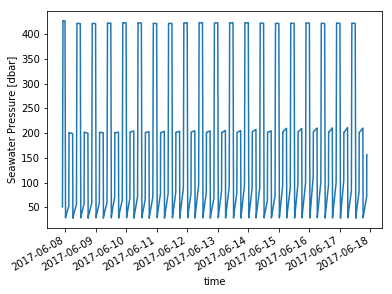

In [11]:
ds['ctdpf_ckl_seawater_pressure'][0:100000].plot();

It looks like during this time period the profiler regularly visited the depths of approximately 425, 50, 250, and 50 in repeating order.

Now, let's take a look at the full timeseries of temperature.  

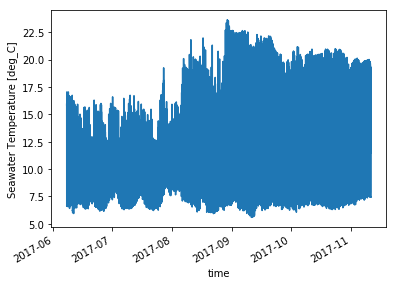

In [12]:
ds['ctdpf_ckl_seawater_temperature'].plot();

This plot is kind of meaningless, because the full depth range of the profiler is also included, but it gives us a general sense of the data.  There is a smaller range in the early summer, which then widens out later on.  Interestingly, warmer waters are still present in October and November.  This could be the result of a warm core ring impinging on the shelf.  Based on this SST image from November 3, 2017, there appears to be a filament in the area.

![Sea Surface Temperature for 11/3/2017](https://marine.rutgers.edu/cool/regions/bigbight/sst_comp/noaa/2017/img/171103.307.comp.lnt.jpg)


Next, let's create some histograms to see the full range of data.  (Thanks to xarray, this is easy to do in just one line!)  Histograms aren't really ideal for understanding a profiler dataset since all depths are included, but let's see what they looks like anyway.

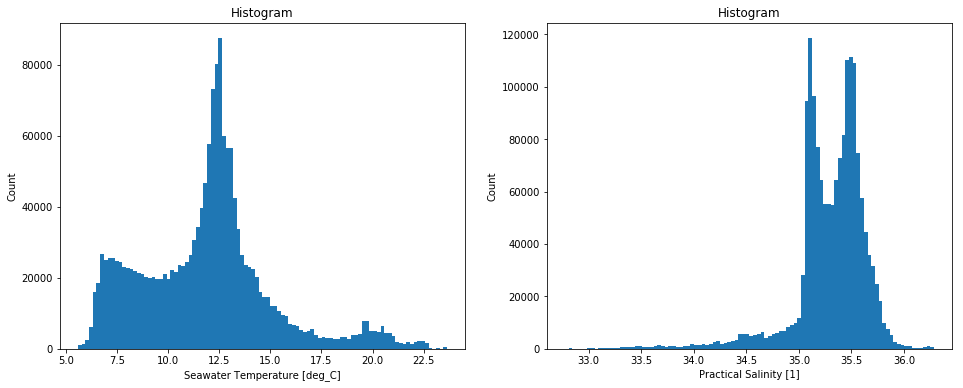

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ds['ctdpf_ckl_seawater_temperature'].plot.hist(bins=100, ax=ax1)
ds['practical_salinity'].plot.hist(bins=100, ax=ax2);


The good news is, the data doesn't appear to include any significant outliers.  As to whether the times of warm temperature or relatively fresher waters are valid, we'd have to look at the dataset more closely, e.g. specific depths or time periods.

So, let's create a profile timeseries to better understand the full dataset.

In [14]:
dtime = ds['time'].values
pressure = ds['ctdpf_ckl_seawater_pressure'].values
temperature = ds['ctdpf_ckl_seawater_temperature'].values
salinity = ds['practical_salinity'].values


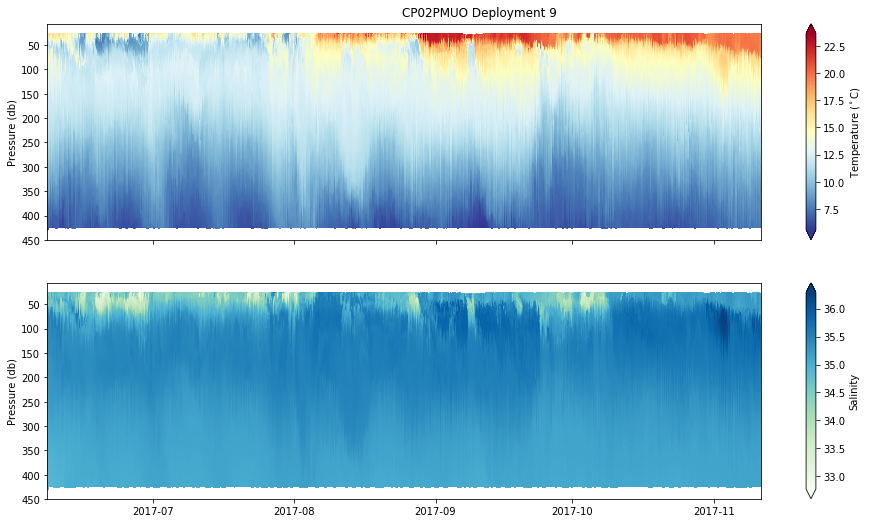

In [15]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,8))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap='GnBu', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (db)')
ax2.set_ylabel('Pressure (db)')

fig.suptitle('CP02PMUO Deployment 9')
fig.subplots_adjust(top=0.95);


## 5. A closer look
Now let's look at one week around the switchover between Deployments 8 and 9.  In step 4, we used a netCDF file.  For this step, we will grab the data directly from the API using a synchronous request, which is limited to 20K datapoints.


In [27]:
# Setup request for instrument data
data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2017-06-01T00:00:00.000Z',
  'endDT':'2017-06-14T00:00:00.000Z',
  'limit':10000,
}

### WARNING: 
#### Data request lines are commented out to prevent accidental resubmission when running through the entire notebook quickly.

In [35]:
# Grab the data
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()

In [29]:
# Process the returned JSON dataset into something we can work with
p_time = []
p_temp = []
p_sal = []
p_pr = []
for i in range(len(data)):
  p_time.append(ntp_seconds_to_datetime(data[i]['time']))
  p_temp.append(data[i]['ctdpf_ckl_seawater_temperature'])
  p_sal.append(data[i]['practical_salinity'])
  p_pr.append(data[i]['ctdpf_ckl_seawater_pressure'])


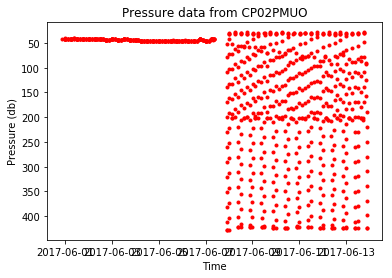

In [30]:
# First, let's make a timeseries of pressure
plt.plot_date(p_time,p_pr,'r.')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Pressure (db)')
plt.title('Pressure data from CP02PMUO');

As noted in the annotation above, during Deployment 8, the profiler stopped profiling in October 2016.  Thus we only have measurements at a single depth for much of that deployment.  However, when the mooring was replaced on June 7, the profiler was once again operational.

For another perspective, let's take a look a look at the temperature and salinity profiles.

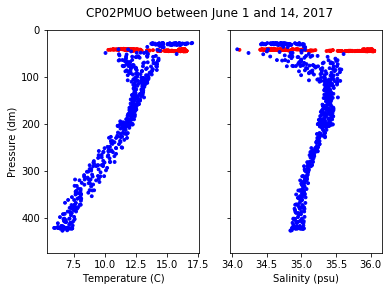

In [31]:
# Profile plots of temperature and salinity
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Create a color map to divide the two deployments
kcolors = ['red' if t<datetime.datetime(2017,6,7,18,53,0) else 'blue' for t in p_time]

ax1.scatter(p_temp,p_pr, c=kcolors, s=8)
# ax1.plot(p_temp,p_pr,'r.')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')
# ax1.invert_yaxis()
ax1.set_ylim(475,0)

ax2.scatter(p_sal,p_pr, c=kcolors, s=8)
# ax2.plot(p_sal,p_pr,'r.',label='Pioneer Profiler')
ax2.set_xlabel('Salinity (psu)')
fig.suptitle('CP02PMUO between June 1 and 14, 2017')
fig.subplots_adjust(top=0.9);


Data before the redeployment is plotting in red, and after is blue.  The temperature data looks reasonable, because at ~50m the temperature seems to vary quite a bit during both weeks.  The higher salinity values that only show up in the first week may not be valid. However, an offshore ring or filament that might have left the area might also explain the difference.  Further investigation is needed (e.g. comparing with other moorings, gliders or satellite data).

## 6. Comparison with a shipboard CTD
Finally, we compare the profiler's CTD with data collected during the Pioneer 9 Cruise, Leg 1, Cast #11, which occurred on 2017-10-24 2027 UTC.  

The raw ascii data file for the CTD cast can be found at the following location. 

In [32]:
# First, specify the data file for the cruise CTD cast
# Downcast
# cruise_data_file = 'https://alfresco.oceanobservatories.org/alfresco/d/d/workspace/SpacesStore/ef3f532b-7570-43d9-b016-6b58c4429b15/dar24011.asc'
# Down and Up Casts
cruise_data_file = 'https://alfresco.oceanobservatories.org/alfresco/d/d/workspace/SpacesStore/0ddd2680-e35d-46bc-ac1a-d350da4f409d/ar24011.asc'

# Read in the data file without headers due to a bug in the file (two of the header names run together)
cruise_data = pd.read_table(cruise_data_file, delim_whitespace=True, header=None, skiprows=1)

# Add back the necessary headers
cruise_data = cruise_data.rename(columns={0:'Pressure', 1:'Temperature', 13:'Salinity'})


In [36]:
# Next let's grab the Profiler data using a synchronous request 
data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2017-10-24T00:00:00.000Z',
  'endDT':'2017-10-25T00:00:00.000Z',
  'limit':1000,
}

### WARNING: 
#### Data request lines are commented out to prevent accidental resubmission when running through the entire notebook quickly.

In [37]:
# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [38]:
# Process the returned JSON dataset into something we can work with
p_time = []
p_temp = []
p_sal = []
p_pr = []
for i in range(len(data)):
  p_time.append(ntp_seconds_to_datetime(data[i]['time']))
  p_temp.append(data[i]['ctdpf_ckl_seawater_temperature'])
  p_sal.append(data[i]['practical_salinity'])
  p_pr.append(data[i]['ctdpf_ckl_seawater_pressure'])


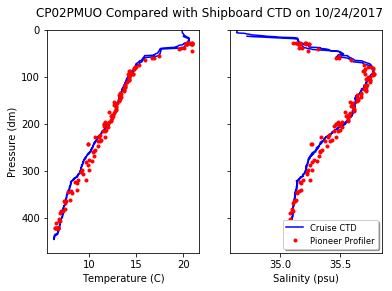

In [39]:
# Now let's plot the Cruise and Profiler data together
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(cruise_data.Temperature,cruise_data.Pressure,'b')
ax1.plot(p_temp,p_pr,'r.')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')
# ax1.invert_yaxis()
ax1.set_ylim(475,0)

ax2.plot(cruise_data.Salinity,cruise_data.Pressure,'b',label='Cruise CTD')
ax2.plot(p_sal,p_pr,'r.',label='Pioneer Profiler')
ax2.set_xlabel('Salinity (psu)')

fig.suptitle('CP02PMUO Compared with Shipboard CTD on 10/24/2017')
fig.subplots_adjust(top=0.9)

legend = ax2.legend(loc='lower right', shadow=True, fontsize='small');


In general, the data from the CTD cast aligns nicely with the profiler data from the same day.  Interestingly, the up and down casts from the shipboard CTD match very well, which often isn't the case.  The profiler matches in general terms with the ship, but there is a bit of variability around the profile.  This could be due to biofouling of the instrument (at this point it had been deployed for over 4 months), or it could be due to the fact that the profiler's data was recorded over the full day wherein values may have changed, while the ship cast was within a few minutes.

## 7. Notable Results and Actions Needed


Based on this (somewhat cursory) analysis of the Pioneer Upstream Offshore Profiler, we note the following takeaways:
* In general, the temperature, salinity and pressure values during deployment 9 look largely reasonable.  There are no major outliers.
* The data seems to align with known physical processes, though additional datasets would need to be consulted to confirm.  This includes:
  * A well defined two-layer system.
  * The surface layer warms and deepens significantly through the summer
  * There are several freshwater surface impulses during the late spring and early fall, which might confirm with rain events
  * The pesistent warm/salty surfaces that persist in the fall may be related to an offshore Gulf Stream filament
* The profiler was inoperative during the end of Deployment 8, remaining at approximately 50m depth, however the CTD data still appears reasonable. An annotation concerning this is already available in the system.
* The profiler data agrees generally with a corresponding shipboard CTD cast.
* Accessing OOI data using Python can be fun!
